In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
import joblib

In [2]:
from preprocess import EstateData

dataset = EstateData("final.csv")

In [3]:
dataset.split_data(stratify=True)

In [4]:
dataset.preprocess(tukey=True)

Start Process!
Fill missing values: Done
Remove outlier: Done
Scale features: Done


In [5]:
train = dataset.train
test = dataset.test

In [6]:
print("train size {}".format(train.shape))
print("test size {}".format(test.shape))

train size (33076, 11)
test size (9278, 11)


In [7]:
train.head()

,House Direction,Balcony Direction,Toilets,Bedrooms,Legits,Floors,Facade,Entrance,X,Y,PricePerM2
44585,None,None,None,6,None,7,-0.371684,0.000000,0.257858,-0.861256,1238.636364
13963,None,None,3,5,+đỏ+hồng,3,0.247790,7.600665,1.033948,0.906604,120.000000
10935,tây nam,tây nam,10+,10+,+đỏ,6,0.504421,-7.399335,0.331334,0.095394,145.454545
3503,None,None,4,4,None,5,-0.396463,-5.899335,0.134339,0.089325,160.714286
23474,tây nam,None,5,3,None,5,-0.247790,0.000000,0.282473,0.647289,168.571429


In [8]:
test.isnull().mean()

House Direction      0.0
Balcony Direction    0.0
Toilets              0.0
Bedrooms             0.0
Legits               0.0
Floors               0.0
Facade               0.0
Entrance             0.0
X                    0.0
Y                    0.0
PricePerM2           0.0
dtype: float64

In [9]:
train, dev = train_test_split(train, test_size=0.1)

In [10]:
features = train.columns.tolist()
features.remove("PricePerM2")


In [11]:
xgb = XGBRegressor(n_estimators = 300, max_depth=15, eta=0.01, gamma=1, tree_method="gpu_hist", subsample=1, objective="reg:squarederror", enable_categorical=True)

In [12]:
xgb.fit(train[features], train["PricePerM2"], eval_set=[(dev[features], dev["PricePerM2"])], eval_metric="mape", early_stopping_rounds=20)

C:\Users\vietdata\anaconda3\envs\ML_env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\vietdata\anaconda3\envs\ML_env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mape:0.98163
[1]	validation_0-mape:0.96904
[2]	validation_0-mape:0.95692
[3]	validation_0-mape:0.94516
[4]	validation_0-mape:0.93370
[5]	validation_0-mape:0.92252
[6]	validation_0-mape:0.91184
[7]	validation_0-mape:0.90167
[8]	validation_0-mape:0.89175
[9]	validation_0-mape:0.88223
[10]	validation_0-mape:0.87296
[11]	validation_0-mape:0.86401
[12]	validation_0-mape:0.85544
[13]	validation_0-mape:0.84708
[14]	validation_0-mape:0.83883
[15]	validation_0-mape:0.83085
[16]	validation_0-mape:0.82294
[17]	validation_0-mape:0.81530
[18]	validation_0-mape:0.80785
[19]	validation_0-mape:0.80047
[20]	validation_0-mape:0.79339
[21]	validation_0-mape:0.78648
[22]	validation_0-mape:0.77952
[23]	validation_0-mape:0.77293
[24]	validation_0-mape:0.76637
[25]	validation_0-mape:0.76004
[26]	validation_0-mape:0.75366
[27]	validation_0-mape:0.74752
[28]	validation_0-mape:0.74147
[29]	validation_0-mape:0.73541
[30]	validation_0-mape:0.72948
[31]	validation_0-mape:0.72382
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eta=0.01, eval_metric=None,
             feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [13]:
with open("log/best_tree.txt", "w") as f:
    f.write(str(xgb.best_ntree_limit))

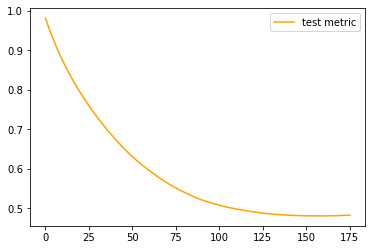

In [14]:
results = xgb.evals_result()
#plt.plot(results["validation_0"]["mape"], c= "b", label="train metric")
plt.plot(results["validation_0"]["mape"], c= "orange", label="test metric")
plt.legend()

In [16]:
pred = xgb.predict(test[features],ntree_limit=xgb.best_ntree_limit)
print(mape(test["PricePerM2"], pred))

C:\Users\vietdata\anaconda3\envs\ML_env\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.4928100257906319


In [16]:
joblib.dump(xgb, "log/best_tree.pkl") 

['log/best_tree.pkl']

In [18]:
joblib.load("log/best_tree.pkl").best_ntree_limit

147

In [22]:
xgb.save_model("log/xgb.json")

In [21]:
0.483118118210765


0.483118118210765

(array([2.291e+03, 5.090e+02, 2.000e+01, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  9.89435,  37.40956,  64.92477,  92.43998, 119.95519, 147.4704 ,
        174.98561, 202.50082, 230.01602, 257.53125, 285.04645],
       dtype=float32),
 <BarContainer object of 10 artists>)

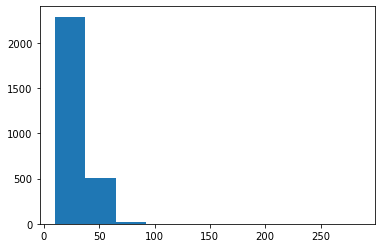

In [25]:
plt.hist(pred)

In [17]:
test["PricePerM2"].describe()

count     9557.000000
mean       893.671987
std       1272.235083
min          0.024000
25%         86.842105
50%        240.000000
75%       1300.000000
max      10000.000000
Name: PricePerM2, dtype: float64

In [20]:
pred = xgb.predict(test[features])
print(r2_score(test["PricePerM2"], pred))


-0.0019258128781889372


(array([9.492e+03, 8.000e+01, 1.900e+01, 5.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-2.73714905e+01,  1.25797259e+06,  2.51597256e+06,  3.77397252e+06,
         5.03197249e+06,  6.28997245e+06,  7.54797242e+06,  8.80597238e+06,
         1.00639723e+07,  1.13219723e+07,  1.25799723e+07,  1.38379722e+07,
         1.50959722e+07,  1.63539722e+07,  1.76119721e+07,  1.88699721e+07,
         2.01279721e+07,  2.13859720e+07,  2.26439720e+07,  2.39019720e+07,
         2.51599719e+07]),
 <BarContainer object of 20 artists>)

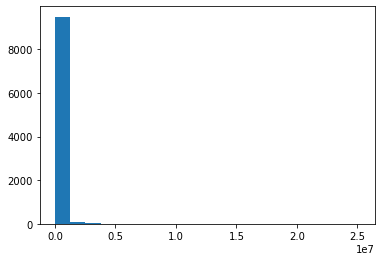

In [31]:
plt.hist(test["Price"].values-pred, bins=20)

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(pd.get_dummies(train[features]).values)

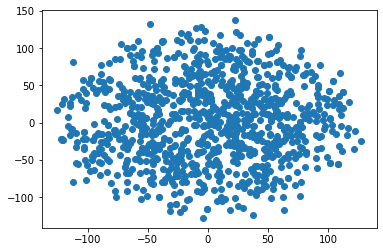

In [40]:
a, b = list(zip(*X_embedded))
plt.scatter(a[:1000],b[:1000])

(array([ 6088., 11138.,  5496.,  3396.,  1929.,  1215.,   697.,   575.,
          341.,   219.]),
 array([ 20.5 ,  38.35,  56.2 ,  74.05,  91.9 , 109.75, 127.6 , 145.45,
        163.3 , 181.15, 199.  ]),
 <BarContainer object of 10 artists>)

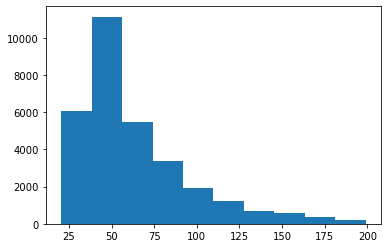

In [362]:
plt.hist(data["Area"][(data["Area"] > 20) & (data["Area"] <200)], bins=10)

In [363]:
data["Area"][(data["Area"] > 20) & (data["Area"] <200)]

0        80.0
1        78.0
2        48.0
3        43.0
4        35.0
         ... 
34951    54.0
34952    75.0
34953    40.0
34954    42.0
34955    50.0
Name: Area, Length: 31094, dtype: float64

<AxesSubplot:ylabel='Frequency'>

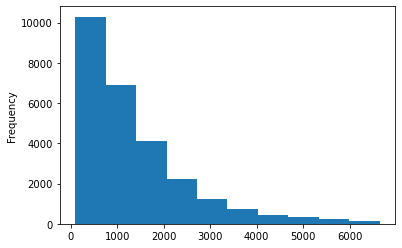

In [492]:
data["Price"].plot(kind="hist")

In [391]:
data[data["Price"] > 300000]

,House Direction,Balcony Direction,Bedrooms,Toilets,Legits,Floors,Facade,Entrance,District,Area,Price
13890,None,None,6,None,+đỏ+hồng,3,17.0,3.0,nam từ liêm,180.0,330000.0
13908,None,None,4,None,+đỏ+hồng,4,5.0,3.0,hoàn kiếm,130.0,330000.0
13931,None,None,10+,None,+đỏ+hồng,9,5.0,3.0,ba đình,89.0,320000.0
14000,None,None,8,None,None,8,5.0,3.0,đống đa,90.0,330000.0
14042,None,None,5,None,+đỏ+hồng,7,7.0,3.0,cầu giấy,120.0,324000.0
...,...,...,...,...,...,...,...,...,...,...,...
34836,None,None,5,None,+đỏ+hồng,5,30.0,3.0,cầu giấy,56.0,310000.0
34842,None,None,3,None,+đỏ+hồng,5,2.0,3.0,long biên,35.0,310000.0
34904,None,None,10+,None,+đỏ+hồng,8,8.0,3.0,cầu giấy,110.0,340000.0
34910,None,None,8,None,+đỏ+hồng,5,10.0,3.0,cầu giấy,100.0,320000.0
